In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [4]:
pos_sig, neg_sig = pd.read_csv("positive_timestamps.csv"), pd.read_csv("negative_timestamps.csv")

In [5]:
pos_sig

,1577111460000
0,1577115180000
1,1577117160000
2,1577117220000
3,1577117460000
4,1577117580000
...,...
75430,1732848180000
75431,1732901400000
75432,1732915500000
75433,1732946220000


In [6]:
pos_sig = np.array(pos_sig)
neg_sig = np.array(neg_sig)


In [11]:
col_names = [
    'timestamp_start', 'open', 'high', 'low', 'close', 'volume', 
    'timestamp_end', 'quote_asset_volume', 'number_of_trades', 
    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
]

In [12]:
btc_df = pd.read_csv('full_BTCUSDT_1m.csv')
ada_df = pd.read_csv('full_ADAUSDT_1m.csv')
bch_df = pd.read_csv('full_BCHUSDT_1m.csv')
bnb_df = pd.read_csv('full_BNBUSDT_1m.csv')
ltc_df = pd.read_csv('full_LTCUSDT_1m.csv')
near_df = pd.read_csv('full_NEARUSDT_1m.csv')
sui_df = pd.read_csv('full_SUIUSDT_1m.csv')

In [13]:
btc_df.columns = col_names
ada_df.columns = col_names
bch_df.columns = col_names
bnb_df.columns = col_names
ltc_df.columns = col_names
near_df.columns = col_names
sui_df.columns = col_names

In [14]:
import warnings 
warnings.filterwarnings('ignore')

### Set timestamps to start index

In [15]:
# Create a dictionary of all crypto DataFrames
crypto_dfs = {
    'BTC': btc_df,
    'ADA': ada_df,
    'BCH': bch_df,
    'BNB': bnb_df,
    'LTC': ltc_df,
    'NEAR': near_df,
    'SUI': sui_df
}

# Function to process all DataFrames
def process_crypto_dataframes(df_dict):
    """
    Process multiple cryptocurrency DataFrames:
    1. Convert timestamp to datetime
    2. Set timestamp as index
    
    Parameters:
    df_dict: Dictionary of DataFrames {symbol: df}
    
    Returns:
    Dictionary of processed DataFrames
    """
    processed_dfs = {}
    
    for symbol, df in df_dict.items():
        # Create a copy to avoid modifying original DataFrame
        processed_df = df.copy()
        
        # Convert timestamp to datetime and set as index
        processed_df['timestamp_start'] = pd.to_datetime(processed_df['timestamp_start'], unit='ms')
        processed_df.set_index('timestamp_start', inplace=True)
        
        processed_dfs[symbol] = processed_df
        
    return processed_dfs

# Process all DataFrames
crypto_dfs = process_crypto_dataframes(crypto_dfs)


In [16]:
crypto_dfs

{'BTC':                              open          high           low         close  \
 timestamp_start                                                               
 2019-12-23 11:58:00   7559.510526   7559.674211   7558.492632   7559.426316   
 2019-12-23 11:59:00   7559.421053   7559.493158   7553.792632   7554.118947   
 2019-12-23 12:00:00   7554.101579   7555.295789   7552.223158   7552.940526   
 2019-12-23 12:01:00   7552.041053   7554.945789   7551.796842   7554.808947   
 2019-12-23 12:02:00   7555.182105   7564.287895   7554.650526   7564.287895   
 ...                           ...           ...           ...           ...   
 2024-11-30 23:55:00  96448.763830  96448.763830  96380.009787  96380.009787   
 2024-11-30 23:56:00  96380.563617  96404.250000  96376.345532  96402.682553   
 2024-11-30 23:57:00  96402.682553  96420.647234  96397.798085  96397.798085   
 2024-11-30 23:58:00  96397.799362  96397.799362  96384.759149  96384.759149   
 2024-11-30 23:59:00  96384.76340

### Regression - 1min Log

In [17]:
def calculate_log_returns(df):
    """Calculate logarithmic returns using close prices"""
    return np.log(df['close'] / df['close'].shift(1))

def analyze_crypto_correlations(crypto_dfs):
    """
    Using concat to only analyze the date range where both BTC and alt coins have data 
    """
    # Calculate BTC returns
    btc_returns = calculate_log_returns(crypto_dfs['BTC'])
    
    # Calculate correlations for each altcoin
    correlations = {}
    for symbol, df in crypto_dfs.items():
        if symbol != 'BTC':  # Skip BTC vs BTC correlation
            alt_returns = calculate_log_returns(df)
            # Align the time series
            matched_data = pd.concat([btc_returns, alt_returns], axis=1).dropna()
            corr = matched_data.iloc[:, 0].corr(matched_data.iloc[:, 1])
            correlations[symbol] = corr
    
    # Create correlation DataFrame
    corr_df = pd.DataFrame.from_dict(correlations, orient='index', 
                                   columns=['correlation'])
    return corr_df.sort_values('correlation', ascending=False)

In [18]:
def plot_correlations(corr_df):
    """
    Create bar plot of correlations similar to paper's Figure 4
    """
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    bars = plt.bar(range(len(corr_df)), corr_df['correlation'])
    
    # Customize the plot
    plt.xticks(range(len(corr_df)), corr_df.index, rotation=45, ha='right')
    plt.ylabel('Correlation Coefficient')
    plt.title('Pearson Correlations on 1min Log Returns between BTC and Altcoins')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    return plt


Correlation Results:
      correlation
BNB      0.719932
ADA      0.711054
LTC      0.638750
BCH      0.583236
SUI      0.516097
NEAR     0.510699


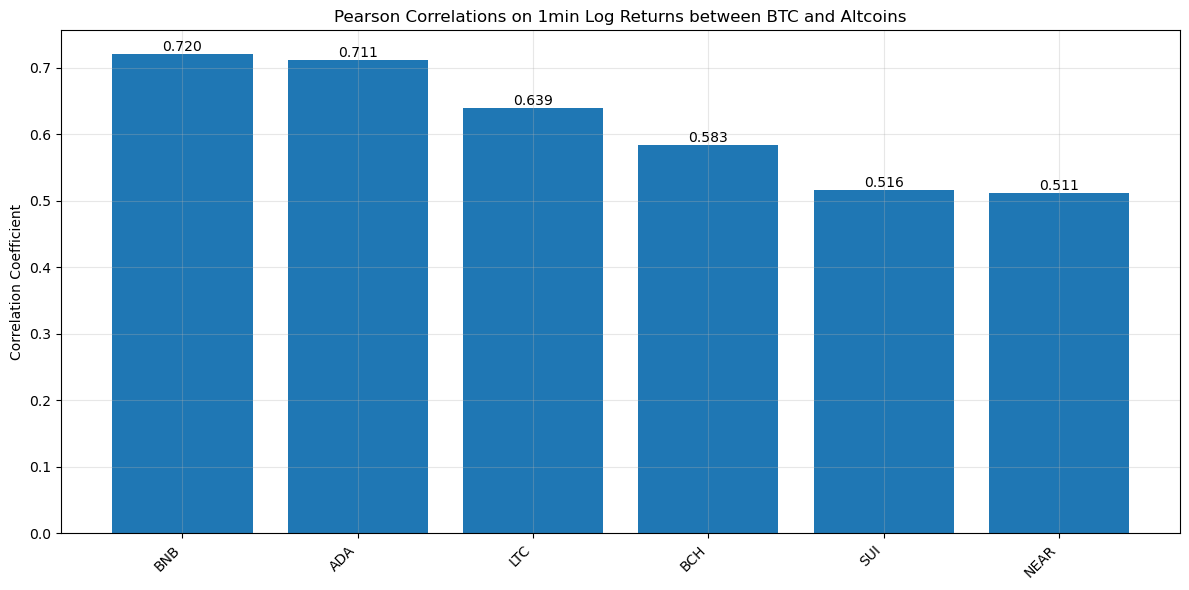

In [19]:
# Calculate correlations
correlations = analyze_crypto_correlations(crypto_dfs)
print("\nCorrelation Results:")
print(correlations)

# Plot results
plot_correlations(correlations)
plt.show()

### 15, 30, 60min Log Regression

In [20]:
def resample_ohlcv(df, timeframe):
    """
    Resample OHLCV data to a larger timeframe
    
    Parameters:
    df: DataFrame with OHLCV data
    timeframe: String representing the new timeframe (e.g. '15T', '30T', '60T')
    
    Returns:
    Resampled DataFrame
    """
    resampled = pd.DataFrame()
    
    # Resample each column according to OHLCV rules
    resampled['open'] = df['open'].resample(timeframe).first()
    resampled['high'] = df['high'].resample(timeframe).max()
    resampled['low'] = df['low'].resample(timeframe).min()
    resampled['close'] = df['close'].resample(timeframe).last()
    resampled['volume'] = df['volume'].resample(timeframe).sum()
    
    return resampled


In [21]:
def analyze_crypto_correlations(crypto_dfs, timeframe):
    """
    Calculate correlations between BTC and all altcoins for a specific timeframe
    
    Parameters:
    crypto_dfs: Dict of all DataFrames including BTC {symbol: df}
    timeframe: String representing the timeframe (e.g. '15T', '30T', '60T')
    
    Returns:
    DataFrame with correlation coefficients
    """
    # Resample BTC data and calculate returns
    btc_resampled = resample_ohlcv(crypto_dfs['BTC'], timeframe)
    btc_returns = calculate_log_returns(btc_resampled)
    
    # Calculate correlations for each altcoin
    correlations = {}
    for symbol, df in crypto_dfs.items():
        if symbol != 'BTC':
            alt_resampled = resample_ohlcv(df, timeframe)
            alt_returns = calculate_log_returns(alt_resampled)
            
            matched_data = pd.concat([btc_returns, alt_returns], axis=1).dropna()
            corr = matched_data.iloc[:, 0].corr(matched_data.iloc[:, 1])
            correlations[symbol] = corr
    
    corr_df = pd.DataFrame.from_dict(correlations, orient='index', 
                                   columns=['correlation'])
    return corr_df.sort_values('correlation', ascending=False)

In [22]:
def plot_multi_timeframe_correlations(corr_dict):
    """
    Create subplots comparing correlations across different timeframes
    
    Parameters:
    corr_dict: Dictionary of correlation DataFrames {timeframe: corr_df}
    """
    fig, axes = plt.subplots(len(corr_dict), 1, figsize=(12, 5*len(corr_dict)))
    
    for idx, (timeframe, corr_df) in enumerate(corr_dict.items()):
        ax = axes[idx] if len(corr_dict) > 1 else axes
        
        # Create bar plot with color gradient
        bars = ax.bar(range(len(corr_df)), corr_df['correlation'])
        colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        # Customize the plot
        ax.set_xticks(range(len(corr_df)))
        ax.set_xticklabels(corr_df.index, rotation=45, ha='right')
        ax.set_ylabel('Correlation Coefficient')
        ax.set_title(f'BTC Correlations ({timeframe} intervals)')
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom')
    
    plt.tight_layout()
    return fig



Correlation Results (15min):
      correlation
LTC      0.752158
BNB      0.745881
ADA      0.717542
BCH      0.677292
NEAR     0.618458
SUI      0.560333

Correlation Results (30min):
      correlation
LTC      0.759411
BNB      0.744128
ADA      0.713760
BCH      0.702758
NEAR     0.618885
SUI      0.549706

Correlation Results (60min):
      correlation
LTC      0.760937
BNB      0.745166
ADA      0.714335
BCH      0.711512
NEAR     0.612438
SUI      0.541494


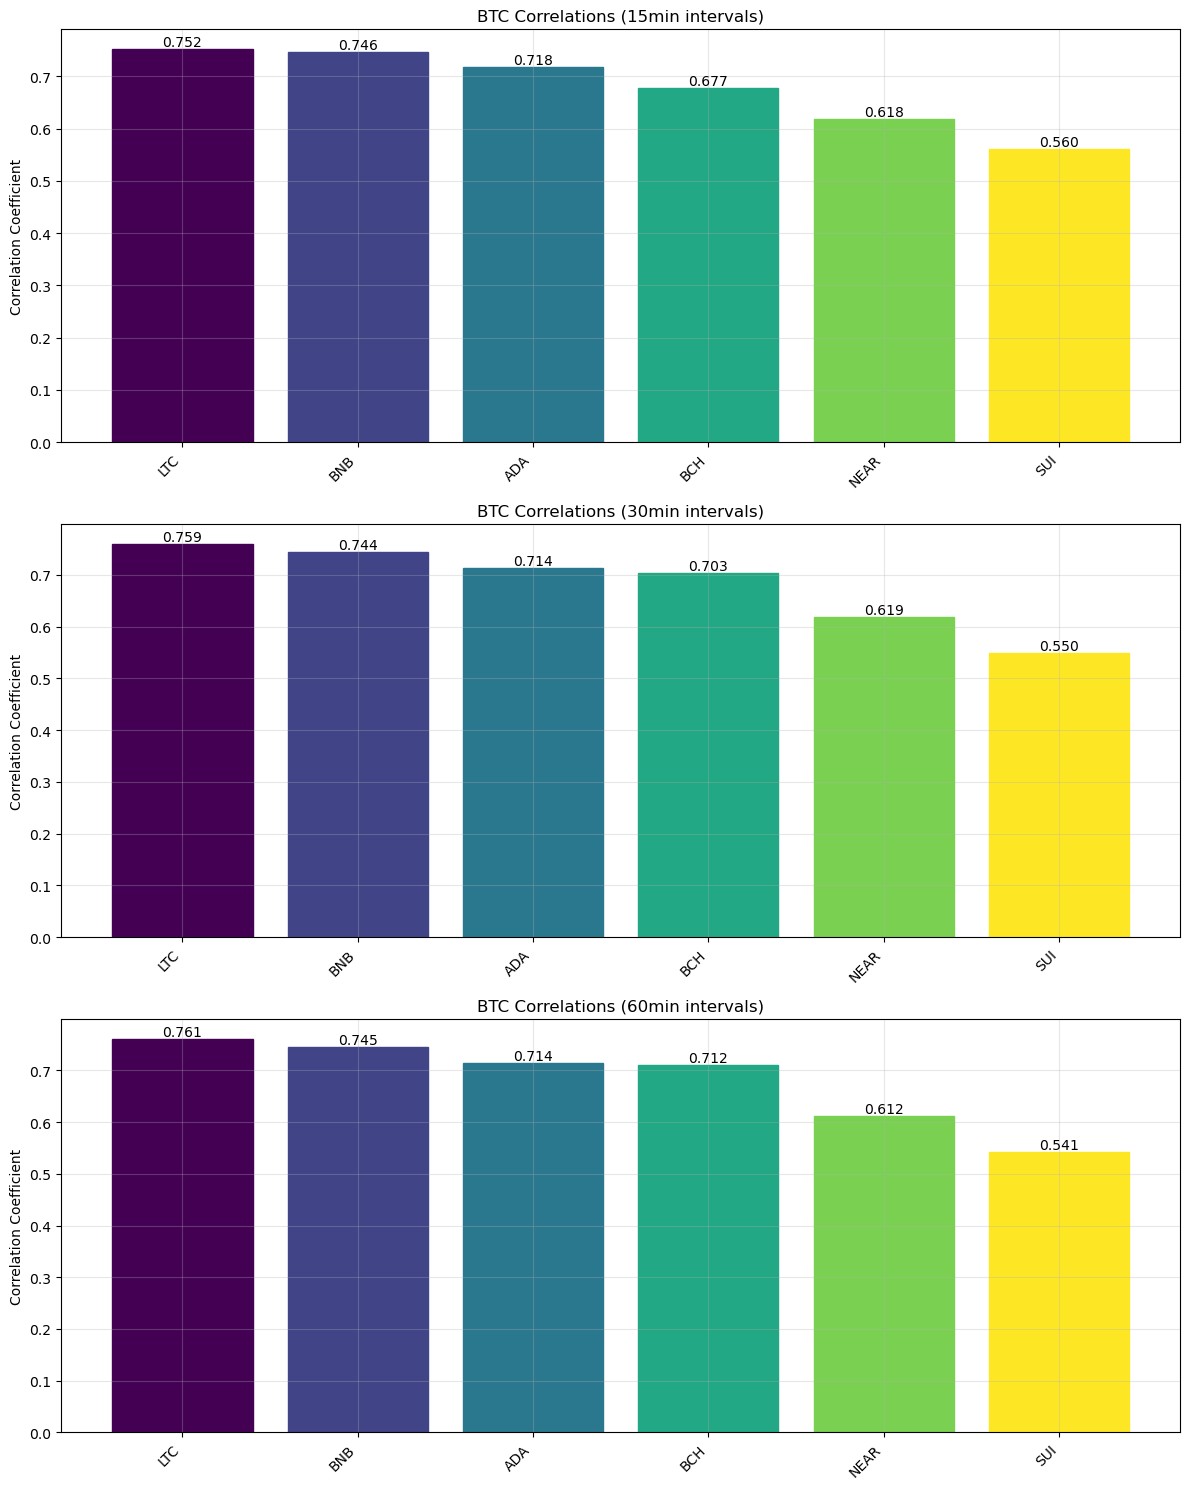

In [23]:
# Define timeframes to analyze
timeframes = {
    '15min': '15T',
    '30min': '30T',
    '60min': '60T'
}

# Calculate correlations for each timeframe
correlation_results = {}
for label, timeframe in timeframes.items():
    correlations = analyze_crypto_correlations(crypto_dfs, timeframe)
    correlation_results[label] = correlations
    print(f"\nCorrelation Results ({label}):")
    print(correlations)

# Plot results
plot_multi_timeframe_correlations(correlation_results)
plt.show()

# Save results to CSV
for timeframe, corr_df in correlation_results.items():
    corr_df.to_csv(f'crypto_correlations_{timeframe}.csv')

### Relationship Analysis

In [25]:
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns

In [26]:
class CryptoRelationshipAnalyzer:
    def __init__(self, btc_df, alt_df, alt_name):
        """Initialize with BTC and altcoin data"""
        self.btc_df = btc_df
        self.alt_df = alt_df
        self.alt_name = alt_name
        
    def resample_data(self, timeframe):
        """Resample data to specified timeframe"""
        btc_resampled = self.btc_df.resample(timeframe).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        })
        
        alt_resampled = self.alt_df.resample(timeframe).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        })
        
        return btc_resampled, alt_resampled
    def calculate_returns(self, df):
        """Calculate log returns"""
        return np.log(df['close'] / df['close'].shift(1))
    
    def calculate_correlations(self, timeframe):
        """Calculate both Pearson and Spearman correlations"""
        btc_resampled, alt_resampled = self.resample_data(timeframe)
        btc_returns = self.calculate_returns(btc_resampled)
        alt_returns = self.calculate_returns(alt_resampled)
        
        # Align data
        matched_data = pd.concat([btc_returns, alt_returns], axis=1).dropna()
        matched_data.columns = ['BTC', self.alt_name]
        
        pearson_corr = matched_data['BTC'].corr(matched_data[self.alt_name])
        spearman_corr = matched_data['BTC'].corr(matched_data[self.alt_name], method='spearman')
        
        return pearson_corr, spearman_corr, matched_data
    
    def calculate_beta(self, timeframe):
        """Calculate market beta (sensitivity to BTC)"""
        _, _, matched_data = self.calculate_correlations(timeframe)
        covariance = matched_data.cov()
        beta = covariance.iloc[0,1] / covariance.iloc[0,0]
        return beta

In [27]:
def analyze_all_pairs(crypto_dfs, timeframes=['1T', '5T', '10T', '15T']):
    """Analyze all BTC-altcoin pairs and return results in a flat DataFrame"""
    results = []
    btc_df = crypto_dfs['BTC']
    
    for symbol, df in crypto_dfs.items():
        if symbol != 'BTC':
            analyzer = CryptoRelationshipAnalyzer(btc_df, df, symbol)
            
            for timeframe in timeframes:
                pearson, spearman = analyzer.calculate_correlations(timeframe)[:2]
                beta = analyzer.calculate_beta(timeframe)
                
                results.append({
                    'Symbol': symbol,
                    'Timeframe': timeframe,
                    'Pearson': pearson,
                    'Spearman': spearman,
                    'Beta': beta
                })
    
    return pd.DataFrame(results)



Results for 1T:
        Pearson  Spearman   Beta
Symbol                          
ADA       0.690     0.672  1.128
BCH       0.628     0.663  1.079
BNB       0.712     0.675  0.891
LTC       0.688     0.672  1.109
NEAR      0.561     0.576  1.272
SUI       0.519     0.514  1.363

Results for 5T:
        Pearson  Spearman   Beta
Symbol                          
ADA       0.720     0.698  1.181
BCH       0.684     0.701  1.094
BNB       0.744     0.707  0.931
LTC       0.751     0.713  1.139
NEAR      0.615     0.615  1.323
SUI       0.558     0.540  1.367

Results for 10T:
        Pearson  Spearman   Beta
Symbol                          
ADA       0.722     0.700  1.181
BCH       0.704     0.707  1.096
BNB       0.749     0.709  0.949
LTC       0.758     0.719  1.145
NEAR      0.619     0.619  1.326
SUI       0.559     0.544  1.378

Results for 15T:
        Pearson  Spearman   Beta
Symbol                          
ADA       0.718     0.702  1.185
BCH       0.677     0.712  1.091
BNB   

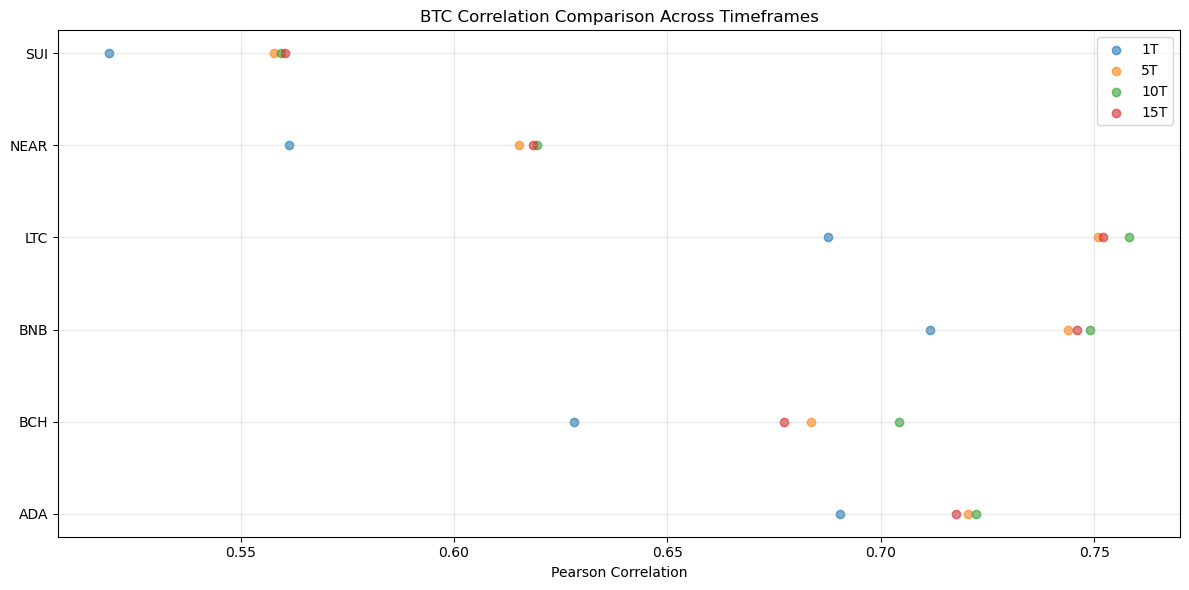

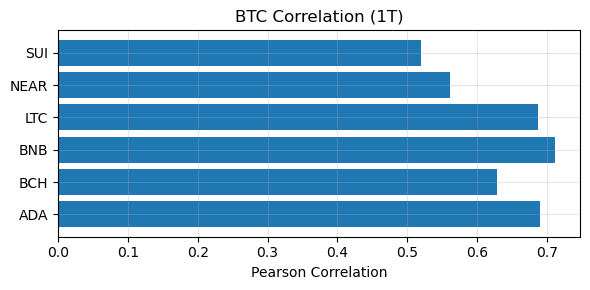

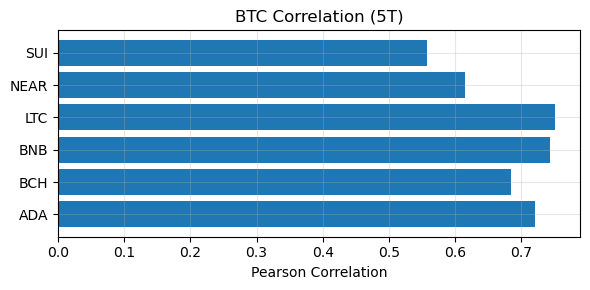

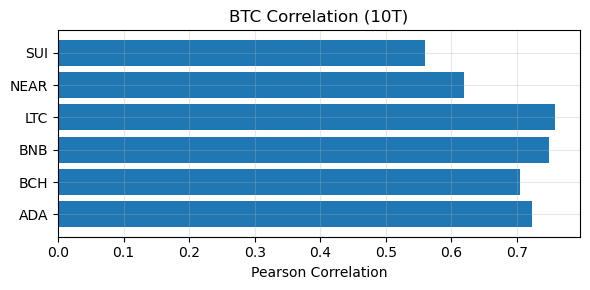

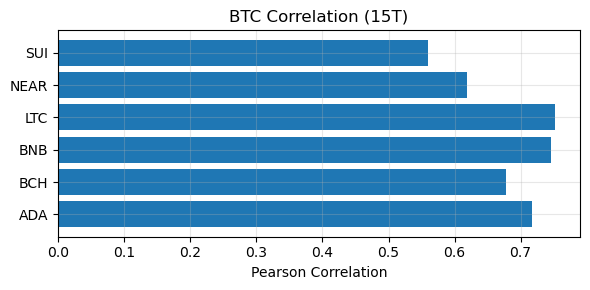

In [28]:
# Run analysis
timeframes = ['1T', '5T', '10T', '15T']
results_df = analyze_all_pairs(crypto_dfs, timeframes)

# Print results for each timeframe
for timeframe in timeframes:
    print(f"\nResults for {timeframe}:")
    timeframe_results = results_df[results_df['Timeframe'] == timeframe].set_index('Symbol')
    print(timeframe_results[['Pearson', 'Spearman', 'Beta']].round(3))

# Plot correlation comparison across timeframes
plt.figure(figsize=(12, 6))
for timeframe in timeframes:
    timeframe_data = results_df[results_df['Timeframe'] == timeframe]
    plt.scatter(timeframe_data['Pearson'], timeframe_data['Symbol'], 
               label=timeframe, alpha=0.6)

plt.xlabel('Pearson Correlation')
plt.title('BTC Correlation Comparison Across Timeframes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create correlation heatmap for each timeframe
for timeframe in timeframes:
    timeframe_data = results_df[results_df['Timeframe'] == timeframe]
    
    plt.figure(figsize=(6, 3))
    plt.barh(timeframe_data['Symbol'], timeframe_data['Pearson'])
    plt.title(f'BTC Correlation ({timeframe})')
    plt.xlabel('Pearson Correlation')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Granger Casualty Test

In [31]:
def test_granger_causality(btc_df, alt_df, symbol, timeframe, maxlag=5):
    """
    Test Granger causality between BTC and altcoin
    """
    try:
        # Get common timeframe
        start = max(btc_df.index.min(), alt_df.index.min())
        end = min(btc_df.index.max(), alt_df.index.max())
        
        # Filter data to common timeframe
        btc_filtered = btc_df[start:end]
        alt_filtered = alt_df[start:end]
        
        # Prepare return data
        btc_resampled = btc_filtered.resample(timeframe).agg({'close': 'last'})
        alt_resampled = alt_filtered.resample(timeframe).agg({'close': 'last'})
        
        btc_returns = np.log(btc_resampled['close'] / btc_resampled['close'].shift(1))
        alt_returns = np.log(alt_resampled['close'] / alt_resampled['close'].shift(1))
        
        data = pd.concat([btc_returns, alt_returns], axis=1).dropna()
        data.columns = ['BTC', 'ALT']
        
        if len(data) < maxlag + 2:  # Minimum required observations
            print(f"Insufficient data for {symbol} at {timeframe}")
            return None
        
        # Test BTC → Altcoin
        btc_to_alt = grangercausalitytests(data, maxlag=maxlag, verbose=False)
        
        # Test Altcoin → BTC
        alt_to_btc = grangercausalitytests(data[['ALT', 'BTC']], maxlag=maxlag, verbose=False)
        
        # Get minimum p-values across all lags
        min_pval_btc_leads = min(btc_to_alt[lag][0]['ssr_chi2test'][1] for lag in range(1, maxlag + 1))
        min_pval_alt_leads = min(alt_to_btc[lag][0]['ssr_chi2test'][1] for lag in range(1, maxlag + 1))
        
        return {
            'Symbol': symbol,
            'Timeframe': timeframe,
            'BTC_leads_pvalue': min_pval_btc_leads,
            'Alt_leads_pvalue': min_pval_alt_leads,
            'Observations': len(data)
        }
        
    except Exception as e:
        print(f"Error testing {symbol} at {timeframe}: {str(e)}")
        return None

In [32]:
def plot_granger_results(results_df, timeframes):
    """
    Plot Granger causality test results with all cryptocurrencies
    """
    fig, axes = plt.subplots(1, len(timeframes), figsize=(20, 6))
    if len(timeframes) == 1:
        axes = [axes]  # Make axes iterable when only one timeframe
        
    for i, timeframe in enumerate(timeframes):
        tf_data = results_df[results_df['Timeframe'] == timeframe]
        
        if len(tf_data) == 0:
            continue
            
        # Convert p-values to -log10 scale with safety checks
        x = -np.log10(tf_data['BTC_leads_pvalue'].clip(1e-10, 1))
        y = -np.log10(tf_data['Alt_leads_pvalue'].clip(1e-10, 1))
        
        # Create scatter plot
        axes[i].scatter(x, y, alpha=0.6)
        
        # Add labels for each point
        for j, symbol in enumerate(tf_data['Symbol']):
            axes[i].annotate(symbol, (x.iloc[j], y.iloc[j]))
            
        # Add significance threshold lines
        sig_threshold = -np.log10(0.05)
        axes[i].axvline(sig_threshold, color='r', linestyle='--', alpha=0.3)
        axes[i].axhline(sig_threshold, color='r', linestyle='--', alpha=0.3)
        
        # Labels and title
        axes[i].set_xlabel('BTC leads (-log10 p-value)')
        axes[i].set_ylabel('Altcoin leads (-log10 p-value)')
        axes[i].set_title(f'Granger Causality ({timeframe})')
        axes[i].grid(True, alpha=0.3)
        
        # Set equal axis limits across all plots
        max_val = max(max(x), max(y)) + 0.5
        min_val = min(min(x), min(y)) - 0.5
        axes[i].set_xlim(min_val, max_val)
        axes[i].set_ylim(min_val, max_val)
    
    plt.tight_layout()
    return fig




Analyzing ADA...

Analyzing BCH...

Analyzing BNB...

Analyzing LTC...

Analyzing NEAR...

Analyzing SUI...

Granger Causality Results for 1T
----------------------------------------
       Timeframe  BTC_leads_pvalue  Alt_leads_pvalue  Observations
Symbol                                                            
ADA           1T               0.0               0.0       1995590
BCH           1T               0.0               0.0       2512348
BNB           1T               0.0               0.0       2487912
LTC           1T               0.0               0.0       2500353
NEAR          1T               0.0               0.0       2097752
SUI           1T               0.0               0.0        824153

Granger Causality Results for 5T
----------------------------------------
       Timeframe  BTC_leads_pvalue  Alt_leads_pvalue  Observations
Symbol                                                            
ADA           5T            0.0000               0.0        399319
BCH 

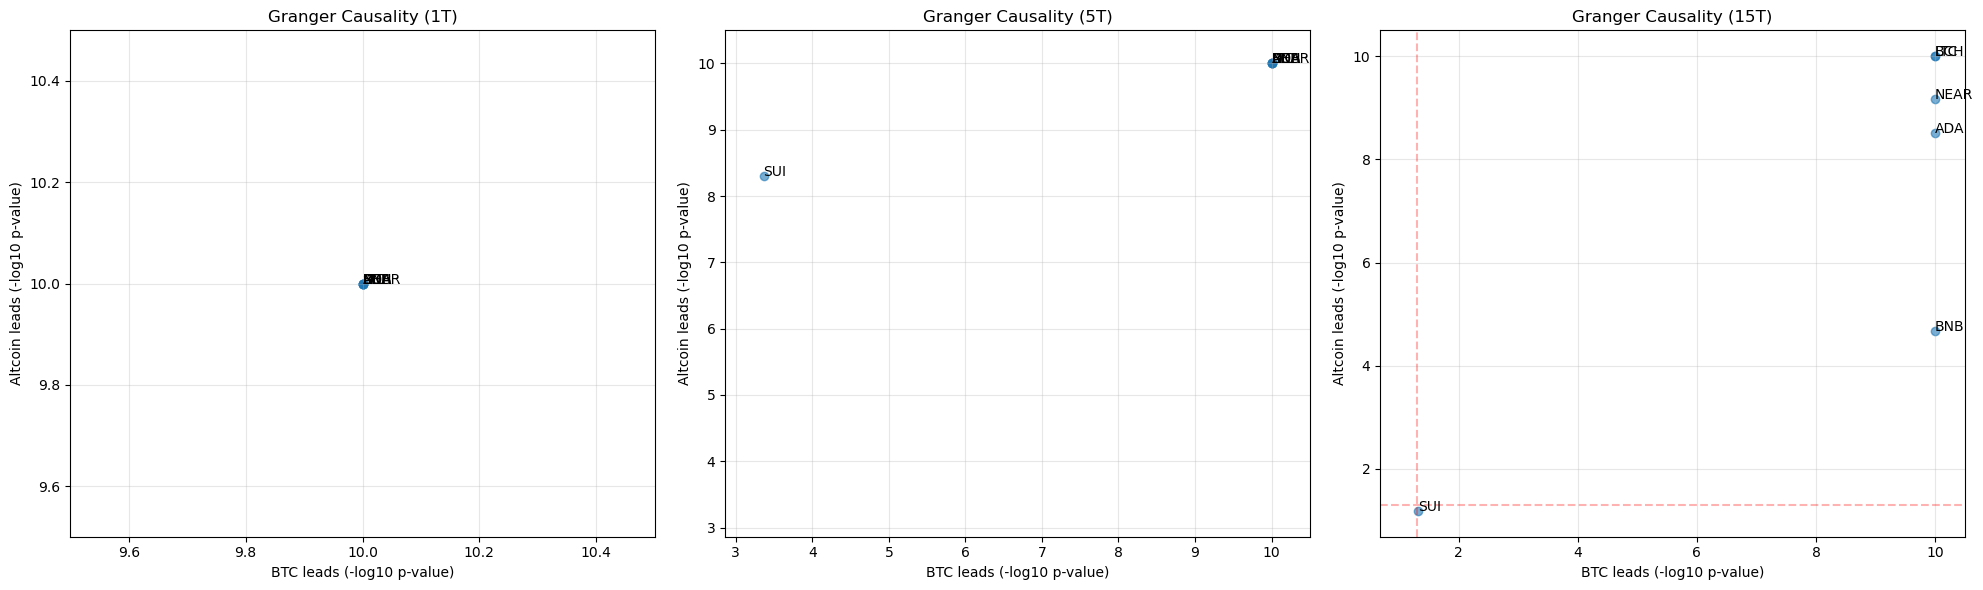

In [33]:
# Run analysis
timeframes = ['1T', '5T', '15T']
results = []

# Create dictionary of altcoin DataFrames (excluding BTC)
altcoin_dfs = {symbol: df for symbol, df in crypto_dfs.items() if symbol != 'BTC'}

# Run Granger tests for each altcoin
for symbol, alt_df in altcoin_dfs.items():
    print(f"\nAnalyzing {symbol}...")
    for timeframe in timeframes:
        result = test_granger_causality(crypto_dfs['BTC'], alt_df, symbol, timeframe)
        if result is not None:
            results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display numerical results
for timeframe in timeframes:
    print(f"\nGranger Causality Results for {timeframe}")
    print("----------------------------------------")
    tf_results = results_df[results_df['Timeframe'] == timeframe].set_index('Symbol')
    if len(tf_results) > 0:
        print(tf_results.round(4))
    else:
        print("No results for this timeframe")

# Plot results
plot_granger_results(results_df, timeframes)
plt.show()

In [34]:
def get_common_timeframe(df1, df2):
    """
    Get the common timeframe between two DataFrames
    """
    start = max(df1.index.min(), df2.index.min())
    end = min(df1.index.max(), df2.index.max())
    return start, end

def analyze_return_distributions(crypto_dfs, timeframe='15T'):
    """
    Analyze return distributions using multiple statistical tests
    """
    results = []
    btc_df = crypto_dfs['BTC']
    
    for symbol, df in crypto_dfs.items():
        if symbol != 'BTC':
            print(f"\nAnalyzing {symbol}...")
            
            # Get common timeframe
            start, end = get_common_timeframe(btc_df, df)
            print(f"Common timeframe: {start} to {end}")
            
            # Filter data to common timeframe
            btc_filtered = btc_df[start:end]
            alt_filtered = df[start:end]
            
            # Resample and calculate returns
            btc_resampled = btc_filtered.resample(timeframe).agg({'close': 'last'})
            alt_resampled = alt_filtered.resample(timeframe).agg({'close': 'last'})
            
            btc_returns = np.log(btc_resampled['close'] / btc_resampled['close'].shift(1)).dropna()
            alt_returns = np.log(alt_resampled['close'] / alt_resampled['close'].shift(1)).dropna()
            
            # Align the time series
            combined = pd.concat([btc_returns, alt_returns], axis=1).dropna()
            combined.columns = ['BTC', 'ALT']
            
            print(f"Number of observations: {len(combined)}")
            
            try:
                # KS test between BTC and altcoin returns
                ks_stat, ks_pval = stats.ks_2samp(combined['BTC'], combined['ALT'])
                
                # T-test between BTC and altcoin returns
                t_stat, t_pval = stats.ttest_ind(combined['BTC'], combined['ALT'])
                
                # Shapiro-Wilk test for normality
                _, sw_pval_btc = stats.shapiro(combined['BTC'])
                _, sw_pval_alt = stats.shapiro(combined['ALT'])
                
                # Calculate basic statistics
                btc_stats = combined['BTC'].describe()
                alt_stats = combined['ALT'].describe()
                
                results.append({
                    'Symbol': symbol,
                    'KS_statistic': ks_stat,
                    'KS_pvalue': ks_pval,
                    'T_statistic': t_stat,
                    'T_pvalue': t_pval,
                    'SW_pvalue_BTC': sw_pval_btc,
                    'SW_pvalue_ALT': sw_pval_alt,
                    'BTC_mean': btc_stats['mean'],
                    'ALT_mean': alt_stats['mean'],
                    'BTC_std': btc_stats['std'],
                    'ALT_std': alt_stats['std'],
                    'Observations': len(combined)
                })
                
                # Create visualization
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
                
                # QQ plots
                sm.graphics.qqplot(combined['BTC'], line='45', fit=True, ax=ax1)
                ax1.set_title(f'BTC Returns QQ Plot')
                
                sm.graphics.qqplot(combined['ALT'], line='45', fit=True, ax=ax2)
                ax2.set_title(f'{symbol} Returns QQ Plot')
                
                # Return distributions
                ax3.hist(combined['BTC'], bins=50, alpha=0.5, label='BTC', density=True)
                ax3.hist(combined['ALT'], bins=50, alpha=0.5, label=symbol, density=True)
                ax3.set_title('Return Distributions')
                ax3.set_xlabel('Log Returns')
                ax3.set_ylabel('Density')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error analyzing {symbol}: {str(e)}")
    
    return pd.DataFrame(results)


In [36]:
from scipy import stats
import statsmodels.api as sm


Analyzing 1T timeframe

Analyzing ADA...
Common timeframe: 2020-01-19 09:10:00 to 2024-11-30 23:59:00
Number of observations: 1995590


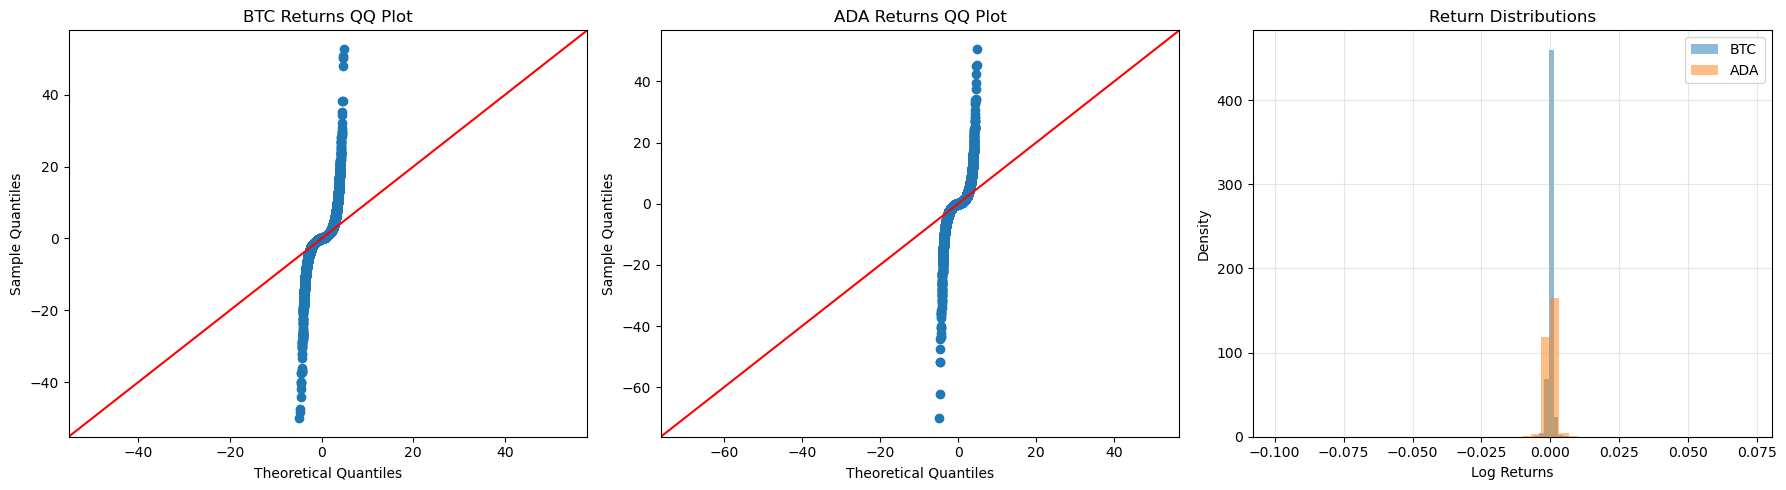


Analyzing BCH...
Common timeframe: 2019-12-31 00:01:00 to 2024-11-30 23:59:00
Number of observations: 2512348


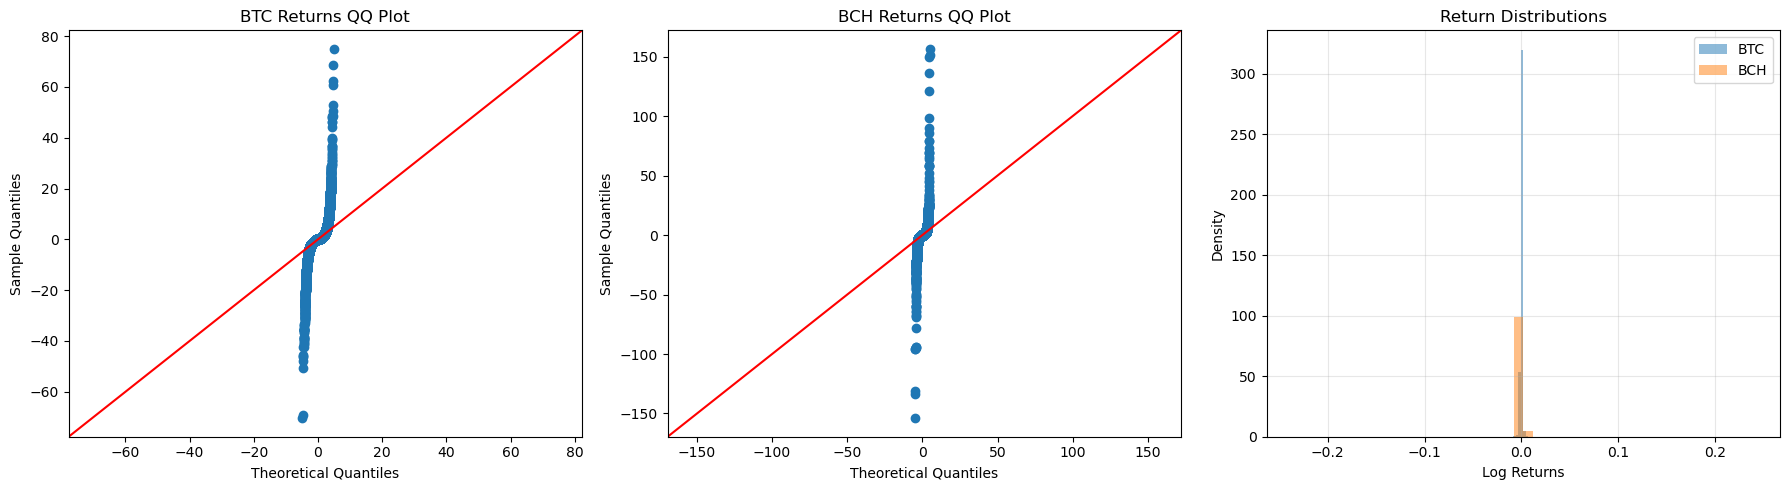


Analyzing BNB...
Common timeframe: 2020-01-01 00:01:00 to 2024-11-30 23:59:00
Number of observations: 2487912


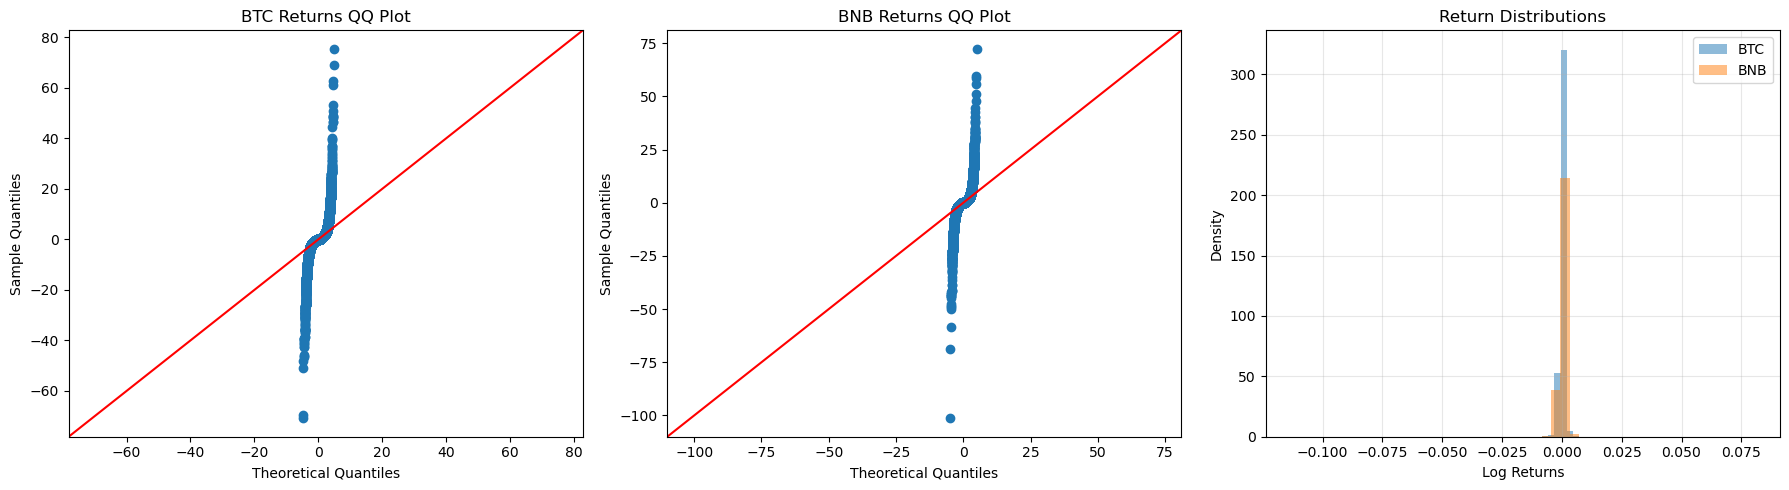


Analyzing LTC...
Common timeframe: 2020-01-09 08:10:00 to 2024-11-30 23:59:00
Number of observations: 2500353


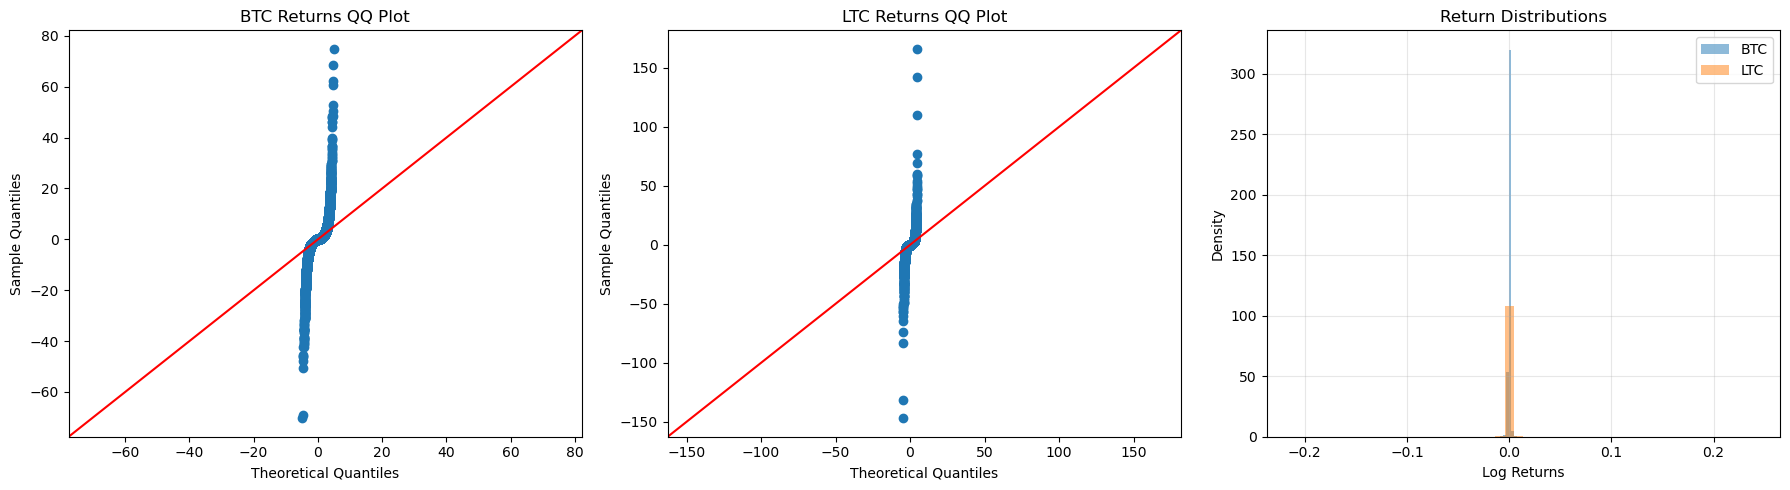


Analyzing NEAR...
Common timeframe: 2020-10-15 08:01:00 to 2024-11-30 23:59:00
Number of observations: 2097752


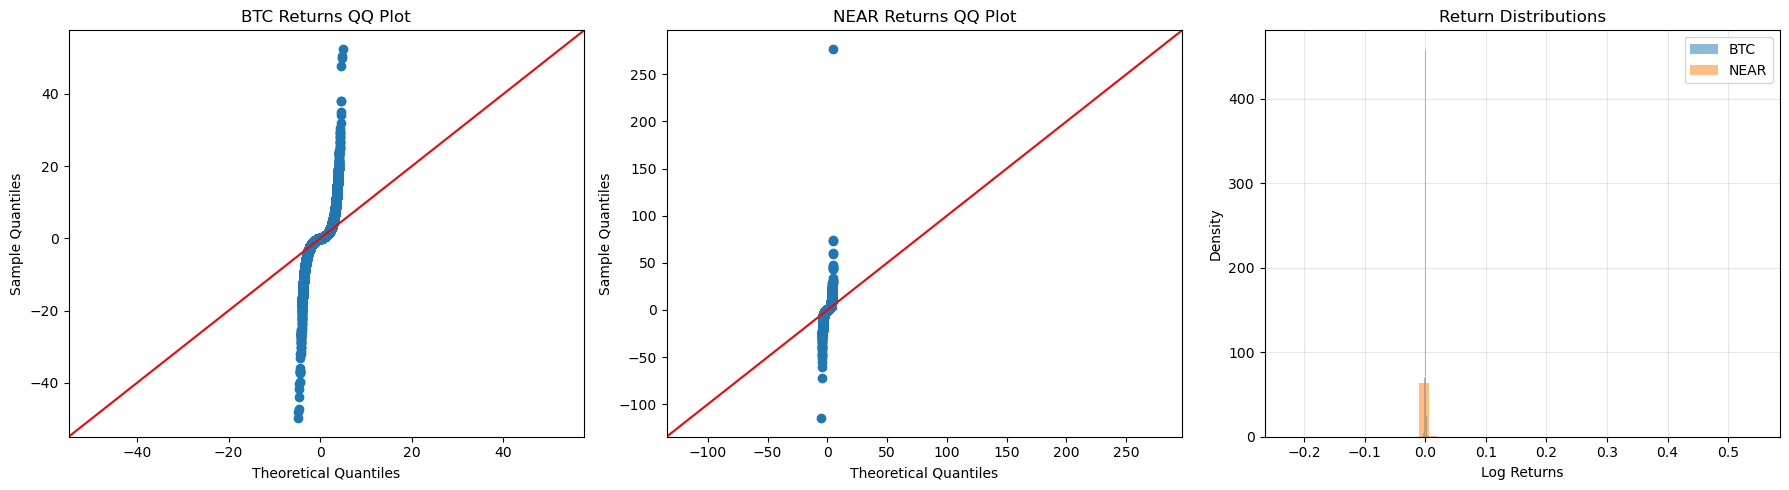


Analyzing SUI...
Common timeframe: 2023-05-03 16:00:00 to 2024-11-30 23:59:00
Number of observations: 824153


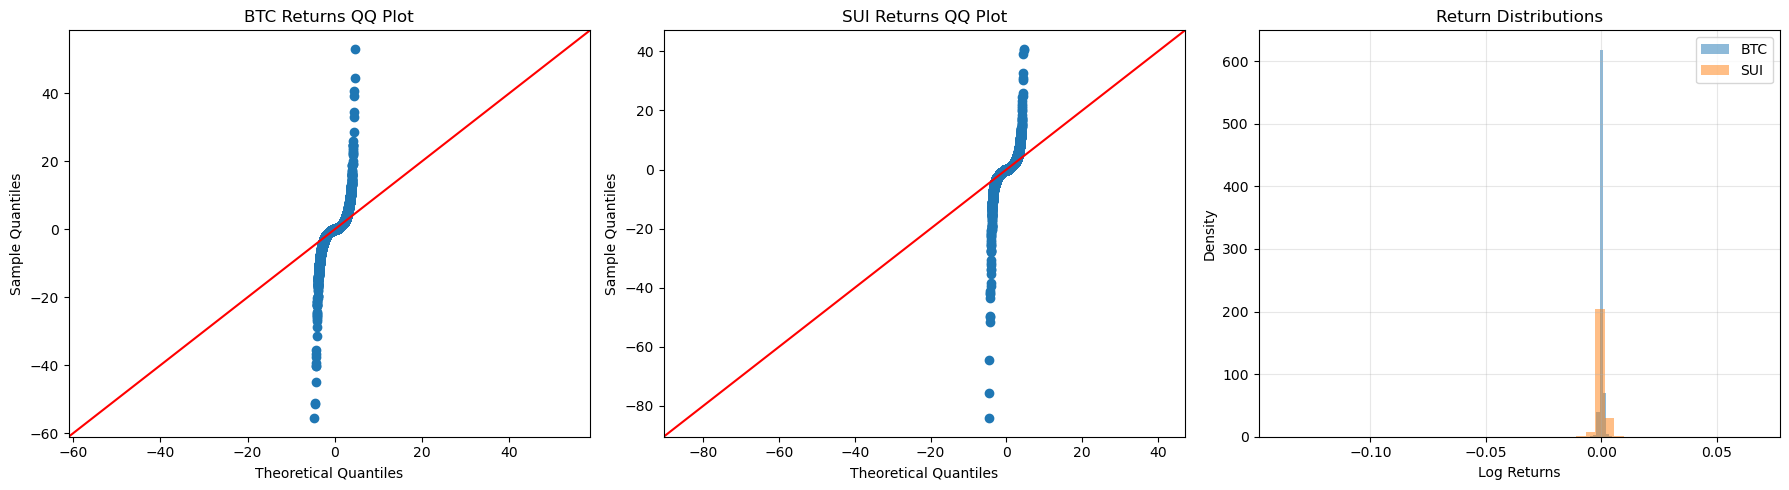


Analyzing 5T timeframe

Analyzing ADA...
Common timeframe: 2020-01-19 09:10:00 to 2024-11-30 23:59:00
Number of observations: 399319


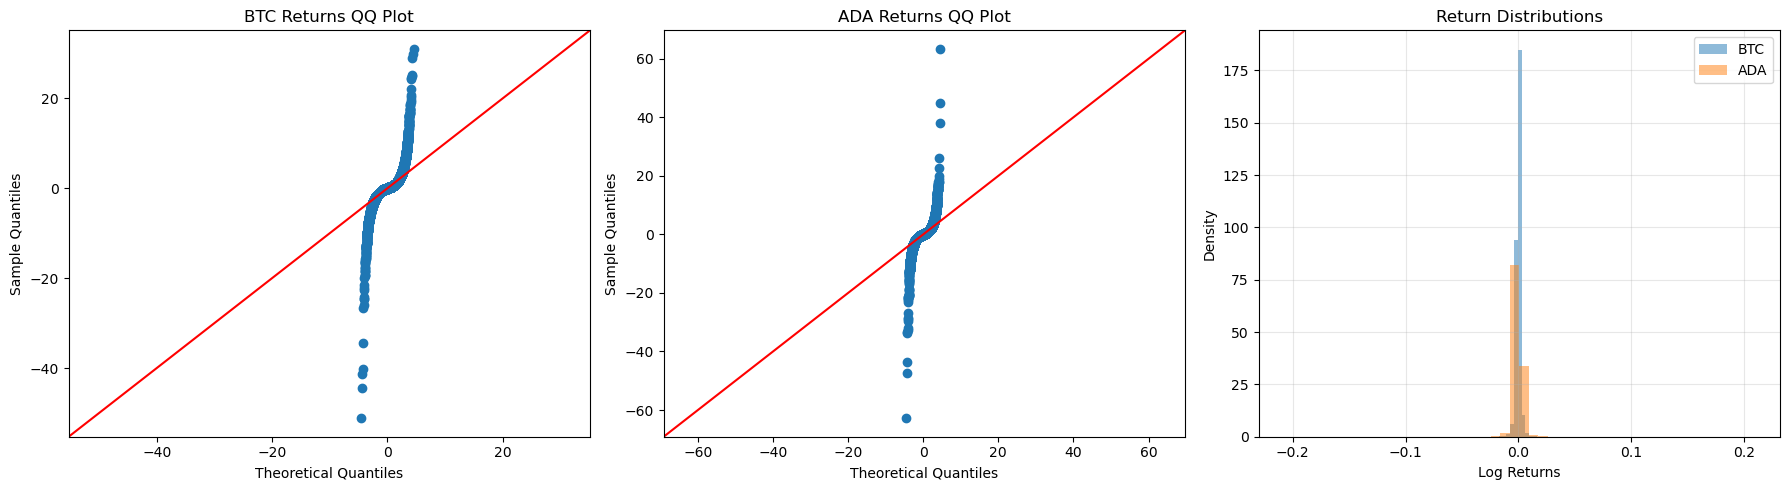


Analyzing BCH...
Common timeframe: 2019-12-31 00:01:00 to 2024-11-30 23:59:00
Number of observations: 502823


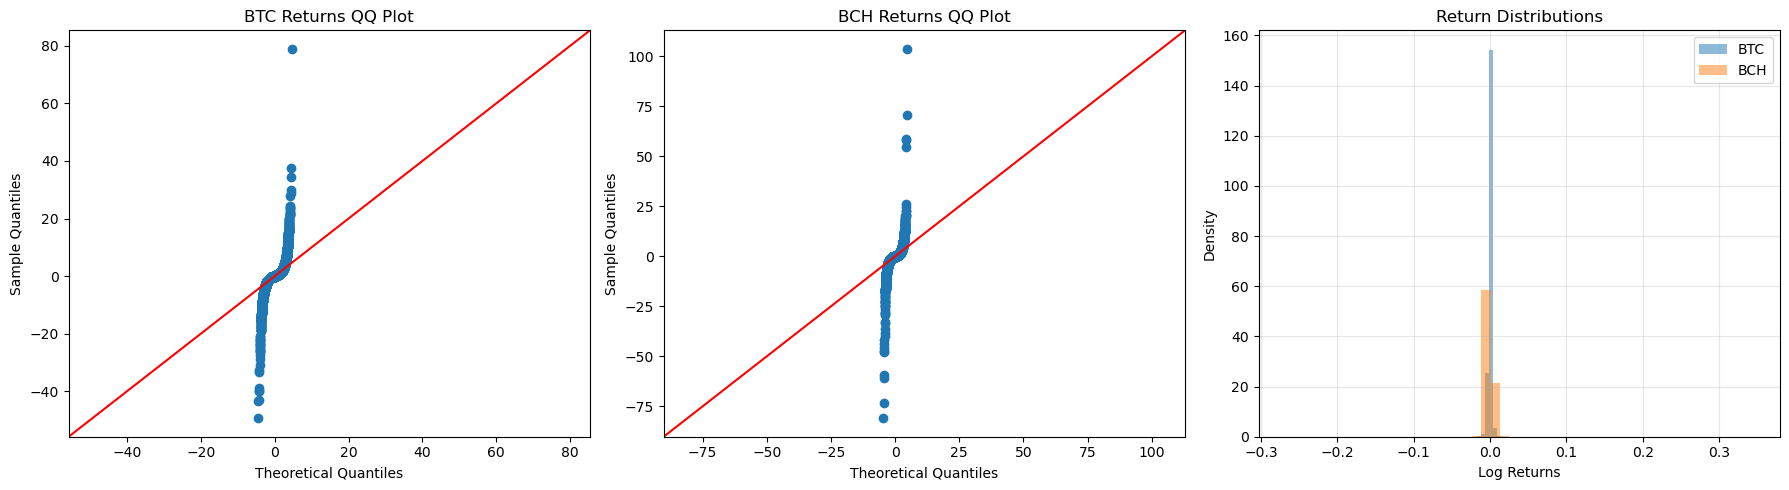


Analyzing BNB...
Common timeframe: 2020-01-01 00:01:00 to 2024-11-30 23:59:00
Number of observations: 497924


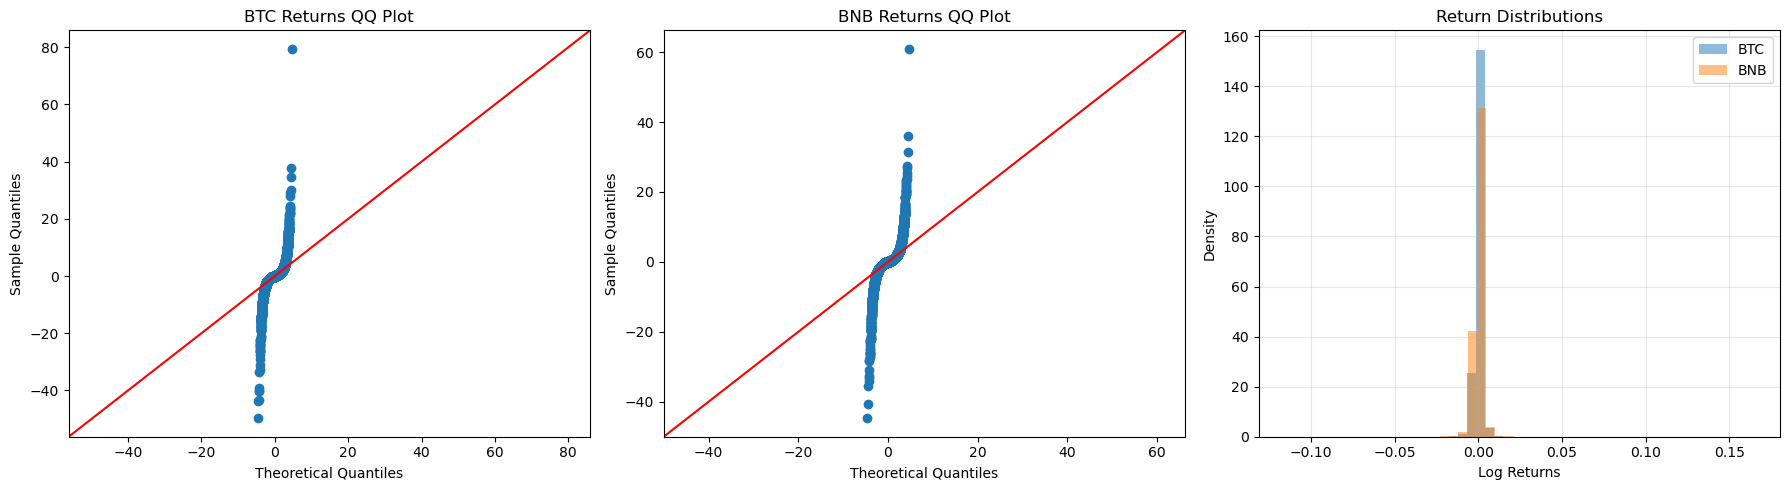


Analyzing LTC...
Common timeframe: 2020-01-09 08:10:00 to 2024-11-30 23:59:00
Number of observations: 500421


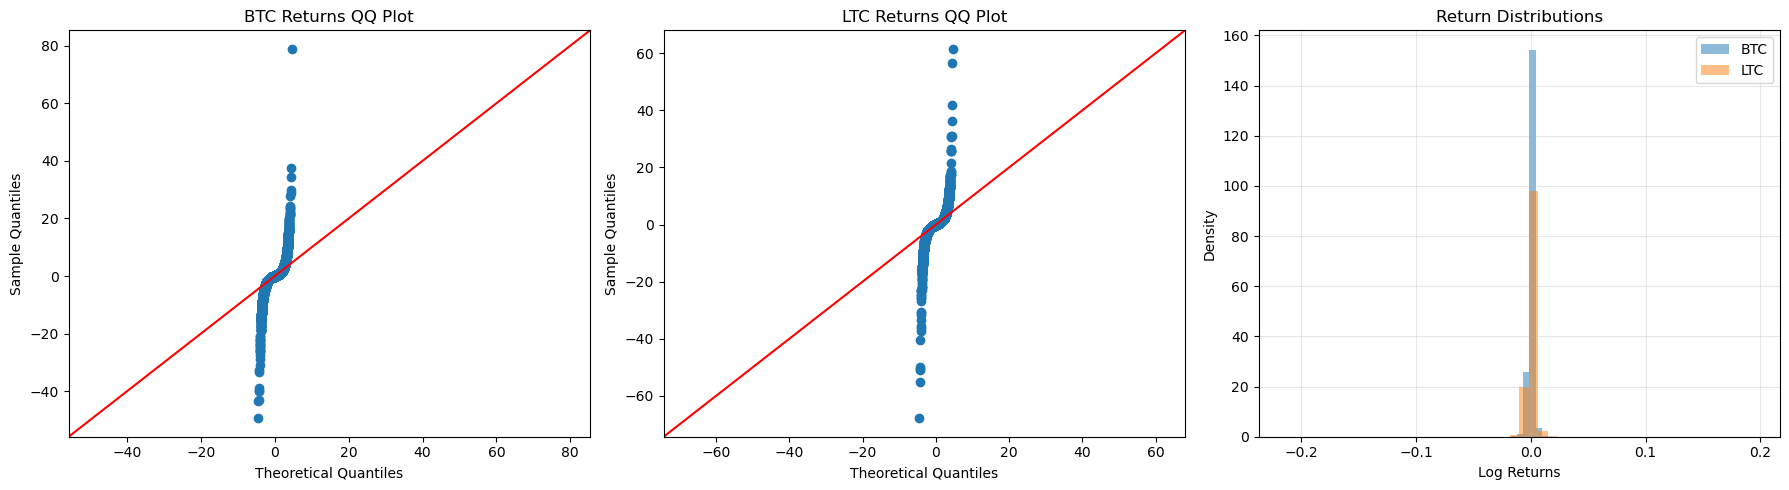


Analyzing NEAR...
Common timeframe: 2020-10-15 08:01:00 to 2024-11-30 23:59:00
Number of observations: 419789


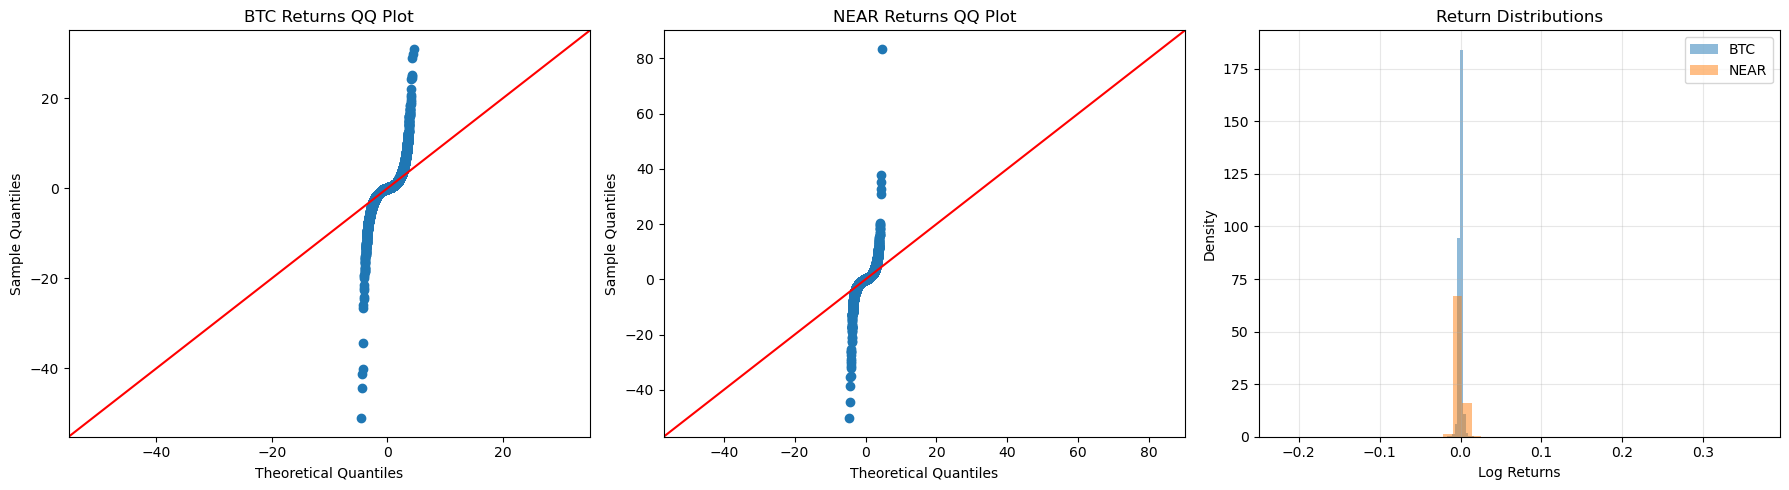


Analyzing SUI...
Common timeframe: 2023-05-03 16:00:00 to 2024-11-30 23:59:00
Number of observations: 164828


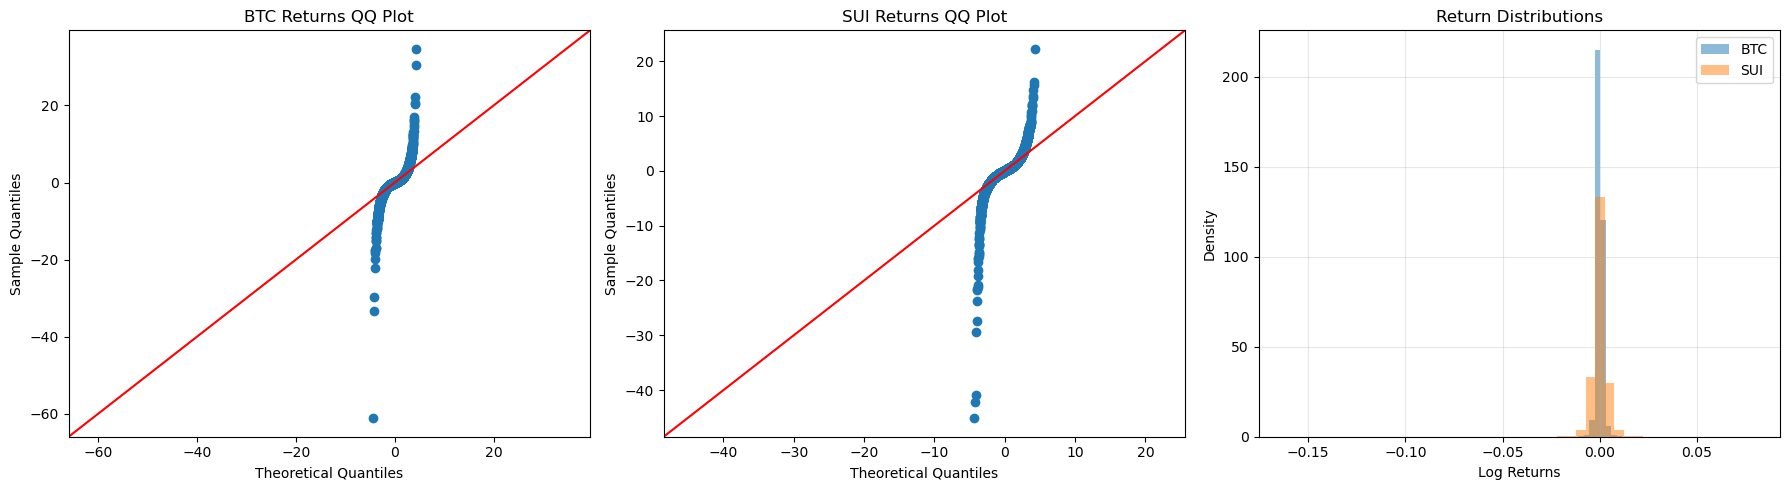


Analyzing 15T timeframe

Analyzing ADA...
Common timeframe: 2020-01-19 09:10:00 to 2024-11-30 23:59:00
Number of observations: 133093


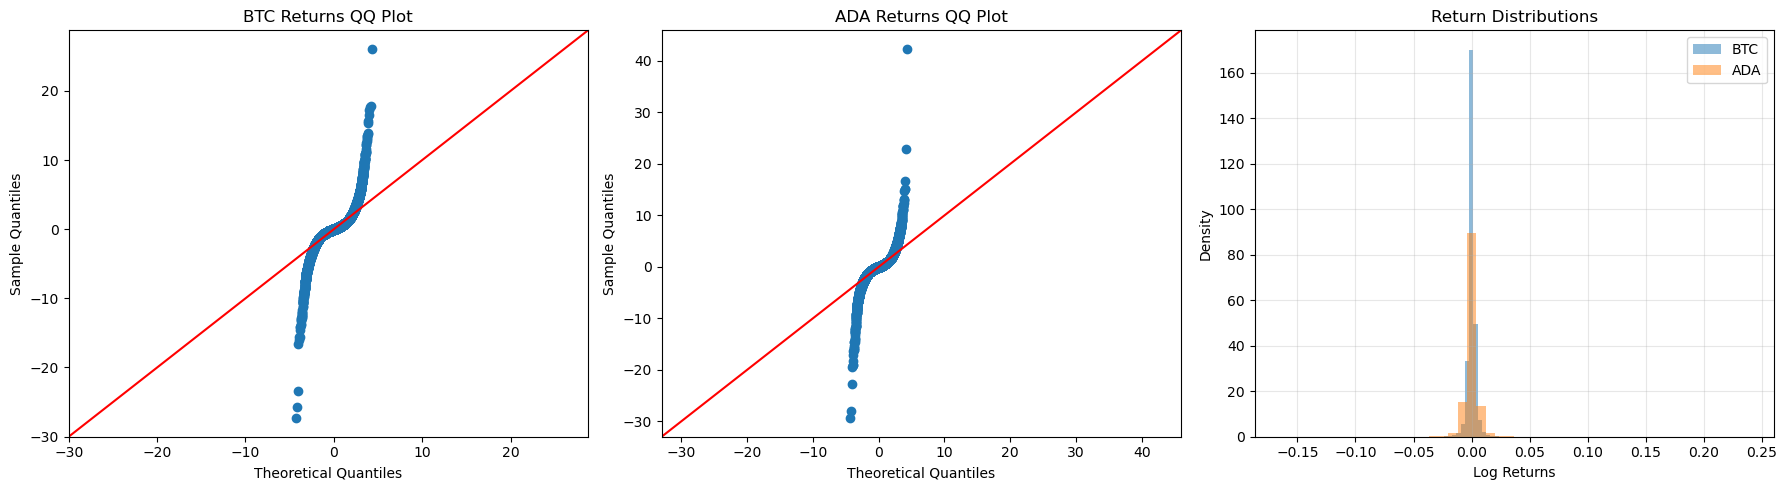


Analyzing BCH...
Common timeframe: 2019-12-31 00:01:00 to 2024-11-30 23:59:00
Number of observations: 167600


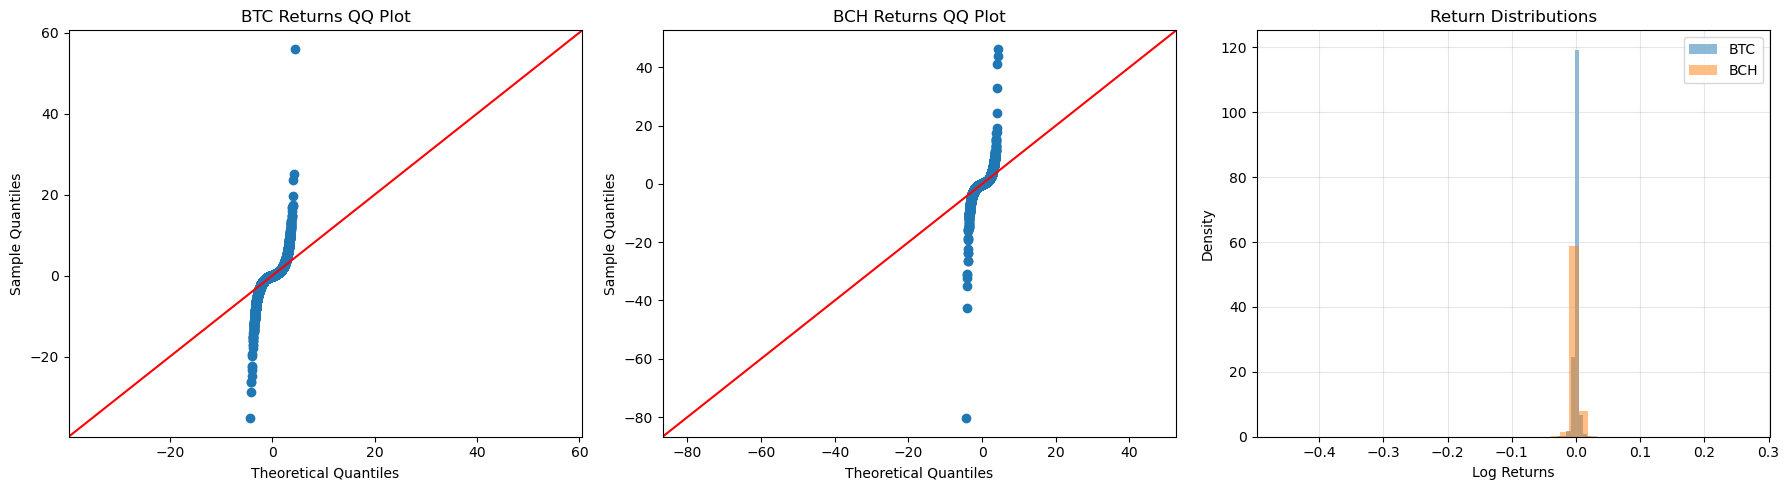


Analyzing BNB...
Common timeframe: 2020-01-01 00:01:00 to 2024-11-30 23:59:00
Number of observations: 165965


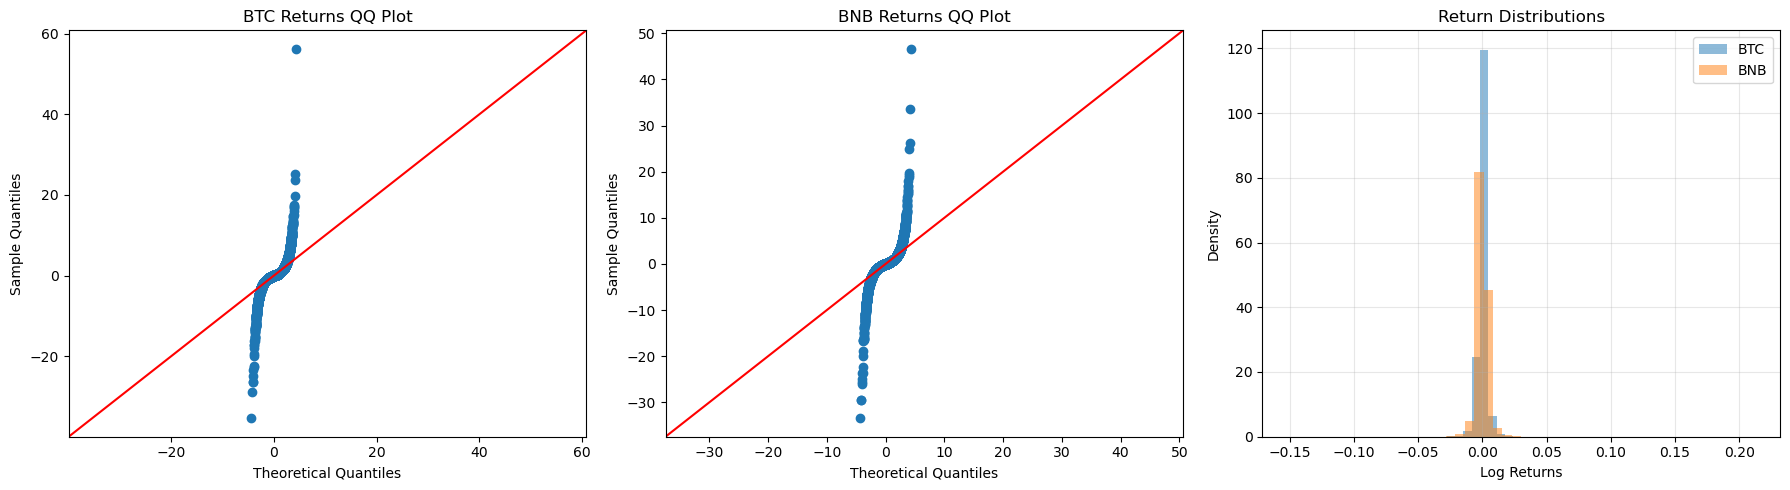


Analyzing LTC...
Common timeframe: 2020-01-09 08:10:00 to 2024-11-30 23:59:00
Number of observations: 166800


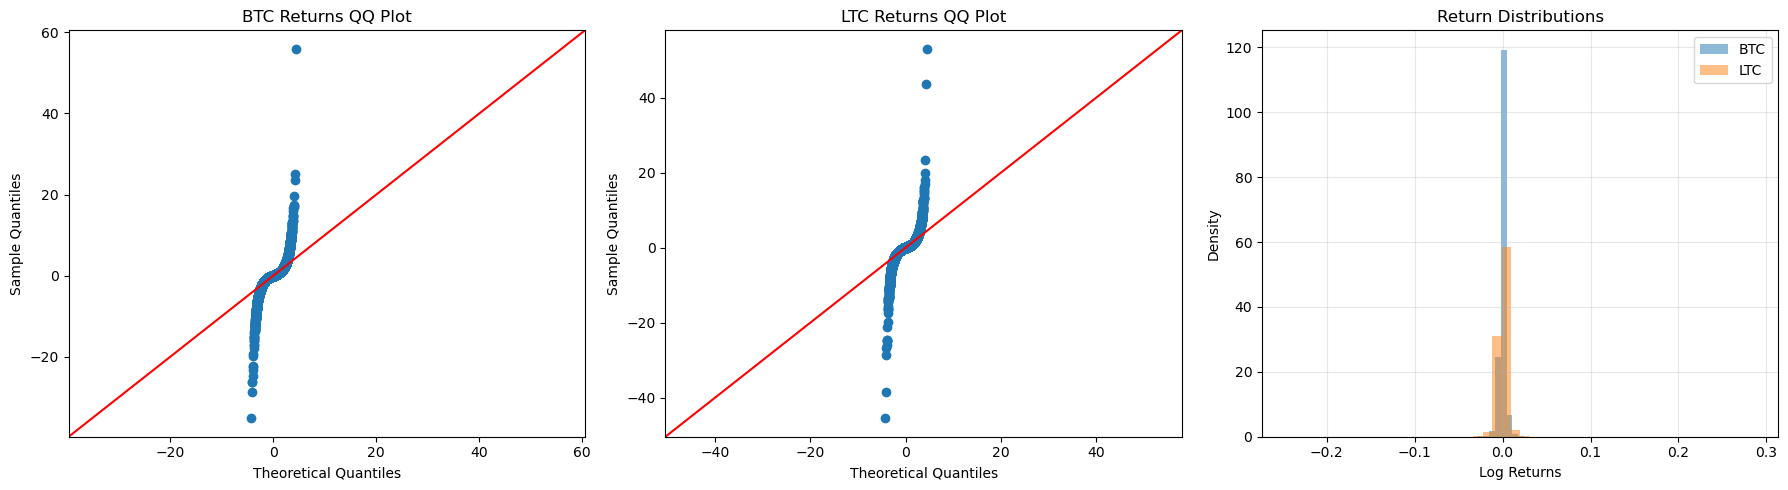


Analyzing NEAR...
Common timeframe: 2020-10-15 08:01:00 to 2024-11-30 23:59:00
Number of observations: 139922


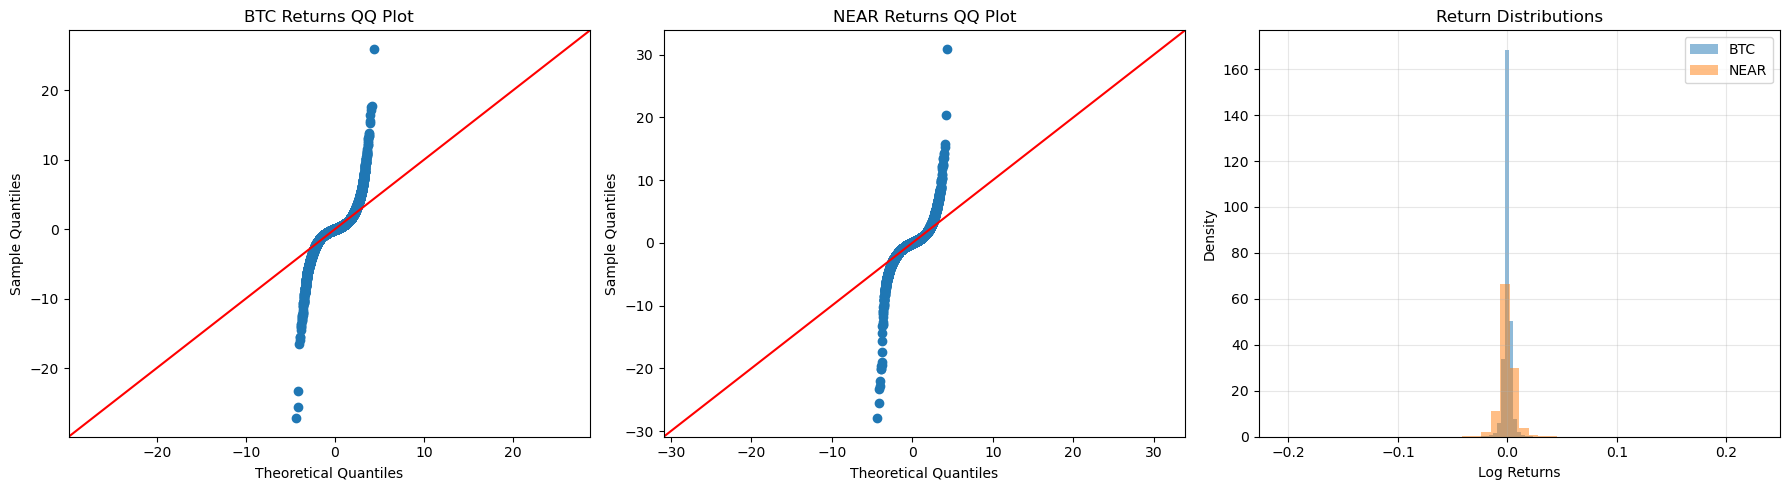


Analyzing SUI...
Common timeframe: 2023-05-03 16:00:00 to 2024-11-30 23:59:00
Number of observations: 54940


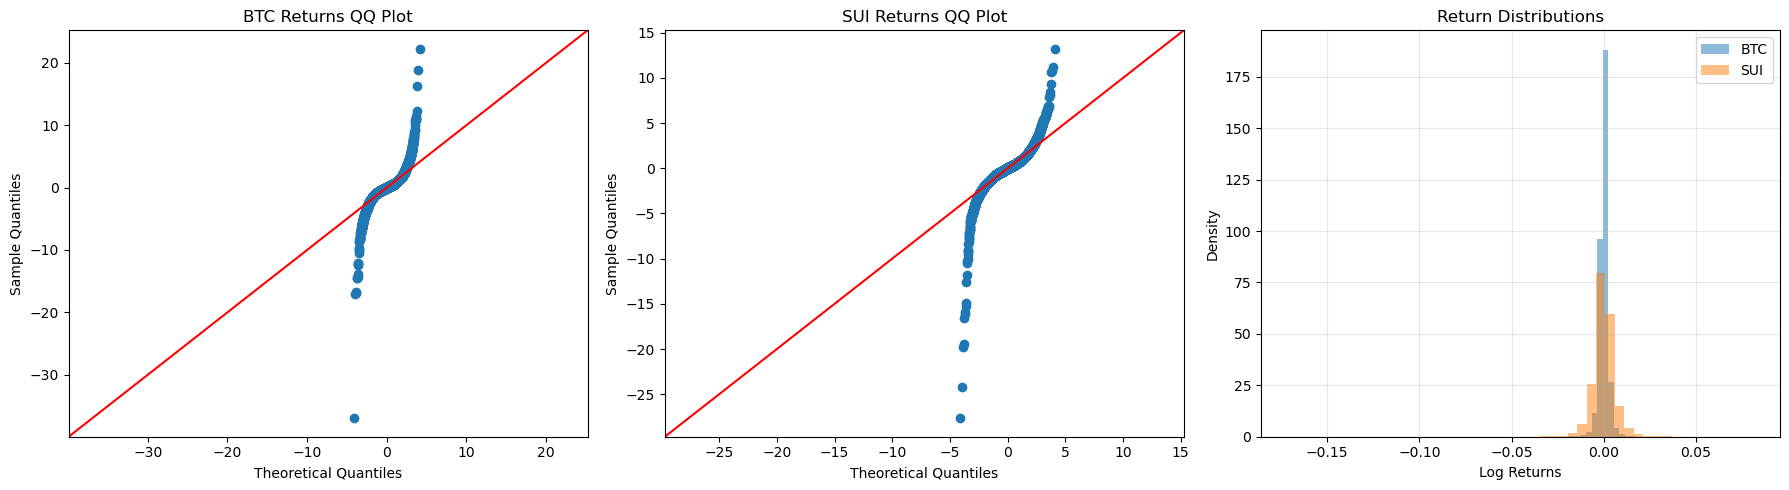


Distribution Analysis Results (1T)

Null Hypotheses:
KS test: Two samples come from the same distribution
T-test: Two samples have the same mean
Shapiro-Wilk test: Sample comes from a normal distribution

Results (p-values < 0.05 indicate rejection of null hypothesis):
  Symbol  KS_pvalue  T_pvalue  SW_pvalue_BTC  SW_pvalue_ALT  BTC_mean  \
0    ADA        0.0    0.9583            0.0            0.0       0.0   
1    BCH        0.0    0.6040            0.0            0.0       0.0   
2    BNB        0.0    0.9520            0.0            0.0       0.0   
3    LTC        0.0    0.5210            0.0            0.0       0.0   
4   NEAR        0.0    0.9052            0.0            0.0       0.0   
5    SUI        0.0    0.8264            0.0            0.0       0.0   

   ALT_mean  Observations  
0       0.0       1995590  
1       0.0       2512348  
2       0.0       2487912  
3       0.0       2500353  
4       0.0       2097752  
5       0.0        824153  

Distribution Analysi

In [37]:
# Run analysis for different timeframes
timeframes = ['1T', '5T', '15T']
all_results = {}

for timeframe in timeframes:
    print(f"\nAnalyzing {timeframe} timeframe")
    print("=" * 50)
    results = analyze_return_distributions(crypto_dfs, timeframe)
    all_results[timeframe] = results

# Display results for each timeframe
for timeframe, results in all_results.items():
    print(f"\nDistribution Analysis Results ({timeframe})")
    print("=" * 50)
    print("\nNull Hypotheses:")
    print("KS test: Two samples come from the same distribution")
    print("T-test: Two samples have the same mean")
    print("Shapiro-Wilk test: Sample comes from a normal distribution")
    print("\nResults (p-values < 0.05 indicate rejection of null hypothesis):")
    
    # Format display columns
    display_cols = ['Symbol', 'KS_pvalue', 'T_pvalue', 'SW_pvalue_BTC', 
                   'SW_pvalue_ALT', 'BTC_mean', 'ALT_mean', 'Observations']
    print(results[display_cols].round(4))
